# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

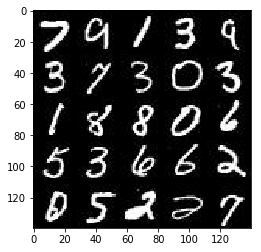

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

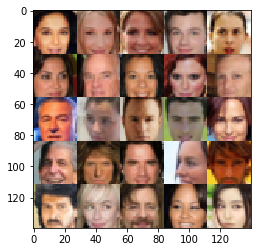

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
alpha = 0.2
dropout = 0.3
smooth = 0.1

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(conv1, rate=dropout, training=True)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(lrelu2, rate=dropout, training=True )

        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 2, 'SAME',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, rate=dropout, training=True)

        
#         # Conv 4
#         conv4 = tf.layers.conv2d(lrelu3, 512, 5, 1, 'SAME',
#                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
#         batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
#         lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
#         dropout4 = tf.layers.dropout(lrelu4 , rate=dropout, training=True)

        # Flatten
        #flat = tf.reshape(dropout4, (-1, 7*7*512))
        flat = tf.reshape(dropout3, (-1,4*4*256))
        #flat = tf.contrib.layers.flatten(dropout4)
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.5
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*512,kernel_initializer=tf.contrib.layers.xavier_initializer())
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        # Starting Conv Transpose Stack
        deconv2 = tf.layers.conv2d_transpose(fc1, 256, 5, 2, 'SAME',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(lrelu2, rate=dropout, training=True)
        
        deconv3 = tf.layers.conv2d_transpose(dropout2, 128, 5, 1, 'SAME',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, rate=dropout, training=True)
        
#         deconv4 = tf.layers.conv2d_transpose(dropout3, 64, 3, 1, 'SAME',
#                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
#         batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
#         lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
#         dropout4 = tf.layers.dropout(lrelu4,rate=dropout, training=is_train)
        
#         deconv5 = tf.layers.conv2d_transpose(dropout4, 32, 3, 2, 'SAME',
#                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
#         batch_norm5 = tf.layers.batch_normalization(deconv5, training=is_train)
#         lrelu5 = tf.maximum(alpha * batch_norm5, batch_norm5)
#         dropout5 = tf.layers.dropout(lrelu5,rate=dropout, training=is_train)
        
        # Logits
        logits = tf.layers.conv2d_transpose(dropout3, out_channel_dim, 5, 2, 'SAME')
        
        # Output
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * (1.0-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 200
    print_every = 30
    train_size = 400
    
    b = tf.Variable(0)
    learning_rate_ = tf.train.exponential_decay(
      lr,                # Base learning rate.
      b ,  # Current index into the dataset.
      train_size,          # Decay step.
      0.60,                # Decay rate.
      staircase=True)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch, batch_images in enumerate(get_batches(batch_size)):
                batch_images *= 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                lr_ = sess.run(learning_rate_, feed_dict={b: steps, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: lr_ })
                                                      
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: lr_ })
                                                      
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: lr_ })
                                                      
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                if steps % print_every == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    learn_rate = learning_rate_.eval({b:batch, lr:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Learning Rate: {:.5f}".format(learn_rate),
                          "Steps: {}".format(steps))
                    
                    #_ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 1.7836... Generator Loss: 0.5923 Learning Rate: 0.00050 Steps: 30
Epoch 1/1... Discriminator Loss: 1.7607... Generator Loss: 0.7108 Learning Rate: 0.00050 Steps: 60
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7291 Learning Rate: 0.00050 Steps: 90
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.9074 Learning Rate: 0.00050 Steps: 120
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6538 Learning Rate: 0.00050 Steps: 150
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6269 Learning Rate: 0.00050 Steps: 180


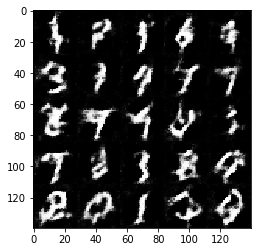

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7750 Learning Rate: 0.00050 Steps: 210
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7870 Learning Rate: 0.00050 Steps: 240
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 1.1556 Learning Rate: 0.00050 Steps: 270
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 1.3157 Learning Rate: 0.00050 Steps: 300
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9379 Learning Rate: 0.00050 Steps: 330
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6559 Learning Rate: 0.00050 Steps: 360
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.5309 Learning Rate: 0.00050 Steps: 390


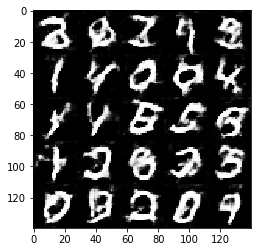

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8747 Learning Rate: 0.00030 Steps: 420
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.6020 Learning Rate: 0.00030 Steps: 450
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.9383 Learning Rate: 0.00030 Steps: 480
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.5754 Learning Rate: 0.00030 Steps: 510
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.5423 Learning Rate: 0.00030 Steps: 540
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7088 Learning Rate: 0.00030 Steps: 570


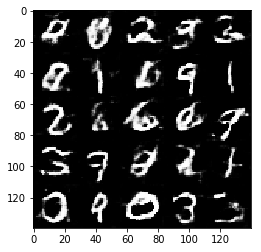

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7772 Learning Rate: 0.00030 Steps: 600
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.2454 Learning Rate: 0.00030 Steps: 630
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.9638 Learning Rate: 0.00030 Steps: 660
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.0590 Learning Rate: 0.00030 Steps: 690
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 1.0841 Learning Rate: 0.00030 Steps: 720
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 1.0272 Learning Rate: 0.00030 Steps: 750
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.3011 Learning Rate: 0.00030 Steps: 780


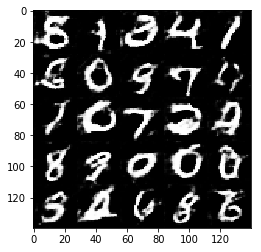

Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.5817 Learning Rate: 0.00018 Steps: 810
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.2923 Learning Rate: 0.00018 Steps: 840
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.8270 Learning Rate: 0.00018 Steps: 870
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8522 Learning Rate: 0.00018 Steps: 900
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.3464 Learning Rate: 0.00018 Steps: 930


IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7501 Learning Rate: 0.00050 Steps: 30
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6714 Learning Rate: 0.00050 Steps: 60
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7611 Learning Rate: 0.00050 Steps: 90
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 1.3991 Learning Rate: 0.00050 Steps: 120
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.5264 Learning Rate: 0.00050 Steps: 150
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.8826 Learning Rate: 0.00050 Steps: 180


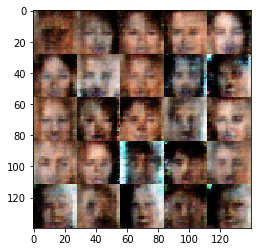

Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.6913 Learning Rate: 0.00050 Steps: 210
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6694 Learning Rate: 0.00050 Steps: 240
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.7387 Learning Rate: 0.00050 Steps: 270
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.6707 Learning Rate: 0.00050 Steps: 300
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.6992 Learning Rate: 0.00050 Steps: 330
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.7664 Learning Rate: 0.00050 Steps: 360
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7971 Learning Rate: 0.00050 Steps: 390


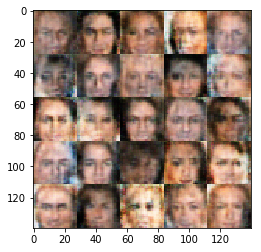

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8730 Learning Rate: 0.00030 Steps: 420
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.8099 Learning Rate: 0.00030 Steps: 450
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7593 Learning Rate: 0.00030 Steps: 480
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.8906 Learning Rate: 0.00030 Steps: 510
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7733 Learning Rate: 0.00030 Steps: 540
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7294 Learning Rate: 0.00030 Steps: 570


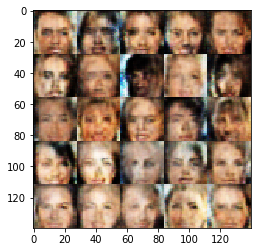

Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7236 Learning Rate: 0.00030 Steps: 600
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6675 Learning Rate: 0.00030 Steps: 630
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7228 Learning Rate: 0.00030 Steps: 660
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7706 Learning Rate: 0.00030 Steps: 690
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.8132 Learning Rate: 0.00030 Steps: 720
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8018 Learning Rate: 0.00030 Steps: 750
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7261 Learning Rate: 0.00030 Steps: 780


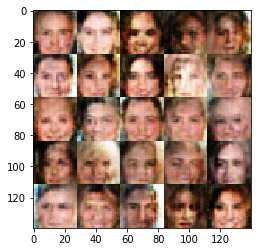

Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6874 Learning Rate: 0.00018 Steps: 810
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8724 Learning Rate: 0.00018 Steps: 840
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7686 Learning Rate: 0.00018 Steps: 870
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7612 Learning Rate: 0.00018 Steps: 900
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7381 Learning Rate: 0.00018 Steps: 930
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7171 Learning Rate: 0.00018 Steps: 960
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7916 Learning Rate: 0.00018 Steps: 990


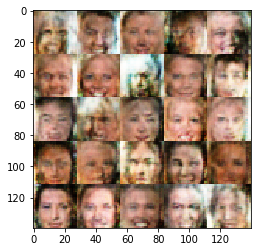

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7314 Learning Rate: 0.00018 Steps: 1020
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7395 Learning Rate: 0.00018 Steps: 1050
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7878 Learning Rate: 0.00018 Steps: 1080
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7909 Learning Rate: 0.00018 Steps: 1110
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8825 Learning Rate: 0.00018 Steps: 1140
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7987 Learning Rate: 0.00018 Steps: 1170


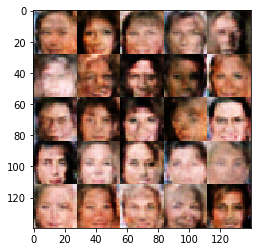

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8173 Learning Rate: 0.00018 Steps: 1200
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7778 Learning Rate: 0.00011 Steps: 1230
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7749 Learning Rate: 0.00011 Steps: 1260
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8669 Learning Rate: 0.00011 Steps: 1290
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8974 Learning Rate: 0.00011 Steps: 1320
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7498 Learning Rate: 0.00011 Steps: 1350
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.8664 Learning Rate: 0.00011 Steps: 1380


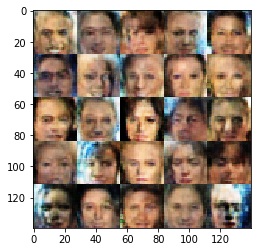

Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7590 Learning Rate: 0.00011 Steps: 1410
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7499 Learning Rate: 0.00011 Steps: 1440
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7097 Learning Rate: 0.00011 Steps: 1470
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8055 Learning Rate: 0.00011 Steps: 1500
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6767 Learning Rate: 0.00011 Steps: 1530
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7629 Learning Rate: 0.00011 Steps: 1560
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6465 Learning Rate: 0.00011 Steps: 1590


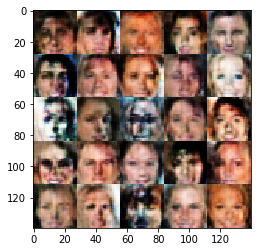

Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7578 Learning Rate: 0.00006 Steps: 1620
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7754 Learning Rate: 0.00006 Steps: 1650
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8163 Learning Rate: 0.00006 Steps: 1680
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7493 Learning Rate: 0.00006 Steps: 1710
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7574 Learning Rate: 0.00006 Steps: 1740
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7864 Learning Rate: 0.00006 Steps: 1770


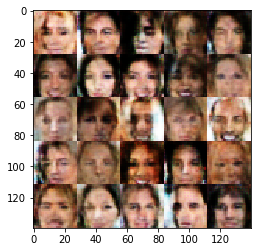

Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.9940 Learning Rate: 0.00006 Steps: 1800
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7021 Learning Rate: 0.00006 Steps: 1830


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.